In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve, classification_report,
                             matthews_corrcoef)
from sklearn.utils.class_weight import compute_class_weight
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [17]:
filename = '女胎plus.xlsx'
data = pd.read_excel(filename)

In [18]:
data

,序号,孕妇代码,Age,Height,Weight,末次月经,IVF妊娠,检测日期,检测抽血次数,GA,...,Unnamed: 21,X染色体浓度,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,AB,怀孕次数,生产次数,胎儿是否健康
0,1,B001,32,162.0,82.0,2023-08-06 00:00:00,自然受孕,20231119,1,13w+5,...,NaN,-0.016976,0.379614,0.392832,0.402970,0.024708,NaN,1,0,是
1,2,B001,32,162.0,82.0,2023-08-06 00:00:00,自然受孕,20231208,2,17w+1,...,NaN,-0.024409,0.377950,0.391176,0.399509,0.025608,NaN,1,0,是
2,3,B001,32,162.0,85.0,2023-08-06 00:00:00,自然受孕,20240101,3,19w+6,...,NaN,-0.016357,0.385021,0.397515,0.408611,0.024452,NaN,1,0,是
3,4,B001,32,162.0,86.0,2023-08-06 00:00:00,自然受孕,20240123,4,23w,...,NaN,-0.021307,0.376070,0.389126,0.397539,0.022412,NaN,1,0,是
4,5,B002,33,165.0,96.0,2023-02-15 00:00:00,自然受孕,20230519,1,12w+5,...,NaN,-0.000886,0.378697,0.391196,0.401632,0.022843,NaN,1,0,是
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,601,B146,34,164.0,90.0,2022-12-31 00:00:00,自然受孕,20230615,4,23w+1,...,NaN,-0.014243,0.381691,0.393509,0.402032,0.019539,T18,≥3,1,是
601,602,B147,32,166.0,86.0,2023-01-08 00:00:00,自然受孕,20230423,1,15w,...,NaN,-0.000855,0.382151,0.395193,0.406132,0.022342,NaN,≥3,1,是
602,603,B147,32,166.0,84.0,2023-01-08 00:00:00,自然受孕,20230513,2,15w+4,...,NaN,-0.006456,0.378540,0.391420,0.400972,0.027777,NaN,≥3,1,是
603,604,B147,32,166.0,86.0,2023-01-08 00:00:00,自然受孕,20230610,3,19w+4,...,NaN,-0.013719,0.379481,0.391826,0.401168,0.022127,NaN,≥3,1,是


In [20]:
import re

def extract_week(x):

    if '+' in x:
   
        week_number = int(re.findall(r'\d+', x)[0])  # 提取 'w' 前面的数字
        extra_days = int(re.findall(r'\d+', x.split('+')[1])[0])  # 提取 '+' 后面的数字
        return week_number + extra_days / 7
    else:
 
        return int(re.findall(r'\d+', x)[0])


data['GA'] = data['GA'].apply(extract_week)



In [21]:
data['BMI'] = pd.to_numeric(data['BMI'], errors='coerce')

# 方法 1：使用最频繁的日期填补
mean_value = data['BMI'].mean()  # 找到最常见的日期
data['BMI'] = data['BMI'].fillna(mean_value)
print(data['BMI'].isnull().sum())

0


In [23]:
data['AB'] = data['AB'].apply(lambda x: 1 if pd.notna(x) and x != '' else 0)

In [24]:
def calculate_metrics(y_true, y_pred, y_prob):
    """计算分类性能指标"""
    # 基本指标
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)  # 敏感性
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # AUC
    try:
        auc = roc_auc_score(y_true, y_prob)
    except:
        auc = 0

    # 平衡准确率
    balanced_acc = (recall + specificity) / 2

    # Matthews相关系数
    mcc = matthews_corrcoef(y_true, y_pred)
    return accuracy, precision, recall, f1, specificity, auc, balanced_acc, mcc


In [33]:
def female_fetus_classification():
    """女胎异常判定分类模型"""

    print("=== 基于前5名指标的女胎异常判定分类模型 ===")

    # 1. 数据读取和预处理

    # 提取前5名相关指标和目标变量
    # 根据前面相关性分析的结果，这里假设前5名指标是：
    feature_columns = ['BMI', 'GA', 'DupRate', 'RawReads', 'Weight']
    target_column = 'AB'

    # 检查列是否存在
    missing_cols = [col for col in feature_columns + [target_column] if col not in data.columns]
    if missing_cols:
        print(f"错误：缺少列 {missing_cols}")
        print(f"可用列: {list(data.columns)}")
        return

    # 提取数据
    X_raw = data[feature_columns].values
    y = data[target_column].values

    # 数据清洗 - 去除含有NaN的行
    valid_mask = ~(np.isnan(X_raw).any(axis=1) | np.isnan(y))
    X_clean = X_raw[valid_mask]
    y_clean = y[valid_mask]

    feature_names = feature_columns

    print(f"\n=== 女胎异常判定模型数据概况 ===")
    print(f"总样本数: {len(y_clean)}")
    print(f"正常样本数: {np.sum(y_clean == 0)} ({100 * np.sum(y_clean == 0) / len(y_clean):.2f}%)")
    print(f"异常样本数: {np.sum(y_clean == 1)} ({100 * np.sum(y_clean == 1) / len(y_clean):.2f}%)")

    # 2. 数据标准化
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X_clean)

    print(f"\n特征统计信息:")
    for i, name in enumerate(feature_names):
        print(f"{name:>10s}: 均值={scaler.mean_[i]:.4f}, 标准差={scaler.scale_[i]:.4f}")

    # 3. 数据分割（训练集70%，测试集30%）
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_clean, test_size=0.3, random_state=42, stratify=y_clean
    )

    print(f"\n数据分割:")
    print(f"训练集: {len(y_train)}样本 (正常:{np.sum(y_train == 0)}, 异常:{np.sum(y_train == 1)})")
    print(f"测试集: {len(y_test)}样本 (正常:{np.sum(y_test == 0)}, 异常:{np.sum(y_test == 1)})")

    # 4. 多种分类模型构建和比较

    # 计算类别权重处理不平衡
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    # 定义模型
    models = {
        '逻辑回归': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        '支持向量机': SVC(random_state=42, class_weight='balanced', probability=True, kernel='rbf'),
        '决策树': DecisionTreeClassifier(random_state=42, class_weight='balanced', min_samples_leaf=5),
        '随机森林': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100),
        '朴素贝叶斯': GaussianNB(),
        '集成学习': AdaBoostClassifier(random_state=42, n_estimators=100)
    }

    # 存储结果
    model_results = {}
    performance_metrics = np.zeros((len(models), 8))  # [准确率,精确率,召回率,F1,特异性,AUC,平衡准确率,MCC]

    print(f"\n=== 多种分类模型训练和评估 ===")

    for i, (model_name, model) in enumerate(models.items()):
        print(f"\n--- 模型{i + 1}: {model_name} ---")

        try:
            # 训练模型
            model.fit(X_train, y_train)

            # 预测
            y_pred = model.predict(X_test)

            # 获取预测概率
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_prob = model.decision_function(X_test)
                # 将决策函数值转换为概率
                y_prob = 1 / (1 + np.exp(-y_prob))
            else:
                y_prob = y_pred.astype(float)

            # 计算性能指标
            accuracy, precision, recall, f1, specificity, auc, balanced_acc, mcc = calculate_metrics(
                y_test, y_pred, y_prob)

            performance_metrics[i, :] = [accuracy, precision, recall, f1, specificity, auc, balanced_acc, mcc]

            # 存储模型和结果
            model_results[model_name] = {
                'model': model,
                'predictions': y_pred,
                'probabilities': y_prob,
                'metrics': [accuracy, precision, recall, f1, specificity, auc, balanced_acc, mcc]
            }

            print(f"准确率: {accuracy:.4f}")
            print(f"精确率: {precision:.4f}, 召回率: {recall:.4f}, F1: {f1:.4f}")
            print(f"特异性: {specificity:.4f}, AUC: {auc:.4f}")
            print(f"平衡准确率: {balanced_acc:.4f}, MCC: {mcc:.4f}")

        except Exception as e:
            print(f"模型训练失败: {e}")
            performance_metrics[i, :] = np.nan

    # 5. 模型性能比较和选择最佳模型
    print(f"\n=== 模型性能综合比较 ===")
    metric_names = ['准确率', '精确率', '召回率', 'F1分数', '特异性', 'AUC', '平衡准确率', 'MCC']
    model_names = list(models.keys())

    # 创建性能比较表
    performance_df = pd.DataFrame(performance_metrics, columns=metric_names, index=model_names)
    print(performance_df.round(4))

    # 选择最佳模型（综合考虑AUC和平衡准确率）
    valid_mask = ~np.isnan(performance_metrics[:, 5])  # AUC不为NaN的模型
    if np.any(valid_mask):
        composite_score = 0.6 * performance_metrics[:, 5] + 0.4 * performance_metrics[:, 6]  # 0.6*AUC + 0.4*平衡准确率
        composite_score[~valid_mask] = -1  # 无效模型得分设为-1
        best_model_idx = np.argmax(composite_score)
        best_model_name = model_names[best_model_idx]
        best_model_data = model_results[best_model_name]

        print(f"\n最佳模型: {best_model_name} (综合得分: {composite_score[best_model_idx]:.4f})")
    else:
        print("所有模型训练失败")
        return

    # 6. 最佳模型详细分析
    print(f"\n=== 最佳模型详细分析 ===")

    # 混淆矩阵
    best_predictions = best_model_data['predictions']
    best_probabilities = best_model_data['probabilities']
    best_model = best_model_data['model']

    cm = confusion_matrix(y_test, best_predictions)
    print("混淆矩阵:")
    print("预测\\实际   正常    异常")
    print(f"正常     {cm[0, 0]:6d}  {cm[0, 1]:6d}")
    print(f"异常     {cm[1, 0]:6d}  {cm[1, 1]:6d}")

    # 特征重要性分析（如果模型支持）
    if hasattr(best_model, 'feature_importances_'):
        print(f"\n特征重要性:")
        importance = best_model.feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        for _, row in importance_df.iterrows():
            print(f"{row['feature']:>10s}: {row['importance']:.4f}")
    elif hasattr(best_model, 'coef_'):
        print(f"\n特征系数:")
        coef = best_model.coef_[0]
        coef_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coef
        }).sort_values('coefficient', key=abs, ascending=False)

        for _, row in coef_df.iterrows():
            print(f"{row['feature']:>10s}: {row['coefficient']:.4f}")

    # 7. 阈值优化
    print(f"\n=== 最优判定阈值分析 ===")

    # 计算不同阈值下的性能
    thresholds = np.arange(0.1, 0.95, 0.05)
    threshold_metrics = np.zeros((len(thresholds), 4))  # [准确率, 召回率, 特异性, F1]

    for i, thresh in enumerate(thresholds):
        pred_thresh = (best_probabilities > thresh).astype(int)

        TP = np.sum((pred_thresh == 1) & (y_test == 1))
        TN = np.sum((pred_thresh == 0) & (y_test == 0))
        FP = np.sum((pred_thresh == 1) & (y_test == 0))
        FN = np.sum((pred_thresh == 0) & (y_test == 1))

        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        threshold_metrics[i, :] = [accuracy, recall, specificity, f1]

    # 寻找最优阈值（最大化F1分数和平衡准确率的组合）
    balanced_accuracy_thresh = (threshold_metrics[:, 1] + threshold_metrics[:, 2]) / 2
    optimal_score = 0.7 * threshold_metrics[:, 3] + 0.3 * balanced_accuracy_thresh
    optimal_idx = np.argmax(optimal_score)
    optimal_threshold = thresholds[optimal_idx]

    print(f"推荐判定阈值: {optimal_threshold:.3f}")
    print(f"该阈值下性能:")
    print(f"  准确率: {threshold_metrics[optimal_idx, 0]:.4f}")
    print(f"  召回率: {threshold_metrics[optimal_idx, 1]:.4f} (敏感性)")
    print(f"  特异性: {threshold_metrics[optimal_idx, 2]:.4f}")
    print(f"  F1分数: {threshold_metrics[optimal_idx, 3]:.4f}")

    # 8. 女胎异常判定方法
    print(f"\n=== 女胎异常判定方法 ===")
    print(f"基于{best_model_name}模型的女胎异常判定方法:\n")

    print("1. 数据预处理:")
    for i, name in enumerate(feature_names):
        print(f"   {name}标准化: ({name} - {scaler.mean_[i]:.4f}) / {scaler.scale_[i]:.4f}")

    print(f"\n2. 判定规则:")
    print(f"   异常概率 = Model_Predict(标准化特征)")
    print(f"   if 异常概率 > {optimal_threshold:.3f}:")
    print(f"       判定结果 = 异常")
    print(f"   else:")
    print(f"       判定结果 = 正常")

    print(f"\n3. 临床应用指导:")
    print(
        f"   - 敏感性(召回率): {threshold_metrics[optimal_idx, 1] * 100:.1f}% (能检出{threshold_metrics[optimal_idx, 1] * 100:.1f}%的真实异常)")
    print(
        f"   - 特异性: {threshold_metrics[optimal_idx, 2] * 100:.1f}% ({threshold_metrics[optimal_idx, 2] * 100:.1f}%的正常会被正确识别)")
    print(f"   - 误诊率(假阳性率): {(1 - threshold_metrics[optimal_idx, 2]) * 100:.1f}%")
    print(f"   - 漏诊率(假阴性率): {(1 - threshold_metrics[optimal_idx, 1]) * 100:.1f}%")

    # 9. 可视化结果
    print(f"\n正在生成可视化结果...")

    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    axes = axes.flatten()
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用SimHei字体
    plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
    # 子图1: 模型性能比较（AUC和平衡准确率）
    valid_performance = performance_metrics[~np.isnan(performance_metrics[:, 5])]
    valid_names = [name for i, name in enumerate(model_names) if not np.isnan(performance_metrics[i, 5])]

    if len(valid_performance) > 0:
        axes[0].scatter(valid_performance[:, 5], valid_performance[:, 6], s=100, alpha=0.7)
        axes[0].scatter(performance_metrics[best_model_idx, 5], performance_metrics[best_model_idx, 6],
                        s=150, c='red', marker='*', label='最佳模型')
        axes[0].set_xlabel('AUC')
        axes[0].set_ylabel('平衡准确率')
        axes[0].set_title('模型性能比较')

        for i, name in enumerate(valid_names):
            axes[0].annotate(f'{i + 1}', (valid_performance[i, 5], valid_performance[i, 6]))
        axes[0].legend()
        axes[0].grid(True)

    # 子图2: ROC曲线
    if len(np.unique(y_test)) > 1:
        fpr, tpr, _ = roc_curve(y_test, best_probabilities)
        auc_score = roc_auc_score(y_test, best_probabilities)
        axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={auc_score:.4f})')
        axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
        axes[1].set_xlabel('假阳性率')
        axes[1].set_ylabel('真阳性率')
        axes[1].set_title('ROC曲线')
        axes[1].legend()
        axes[1].grid(True)

    # 子图3: 阈值分析
    axes[2].plot(thresholds, threshold_metrics[:, 1], 'b-', linewidth=2, label='召回率(敏感性)')
    axes[2].plot(thresholds, threshold_metrics[:, 2], 'r-', linewidth=2, label='特异性')
    axes[2].plot(thresholds, threshold_metrics[:, 3], 'g-', linewidth=2, label='F1分数')
    axes[2].axvline(optimal_threshold, color='k', linestyle='--', linewidth=2, label='最优阈值')
    axes[2].set_xlabel('判定阈值')
    axes[2].set_ylabel('性能指标')
    axes[2].set_title('阈值优化分析')
    axes[2].legend()
    axes[2].grid(True)

    # 子图4: 混淆矩阵热力图
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[3])
    axes[3].set_title('混淆矩阵')
    axes[3].set_xlabel('实际类别')
    axes[3].set_ylabel('预测类别')
    axes[3].set_xticklabels(['正常', '异常'])
    axes[3].set_yticklabels(['正常', '异常'])

    # 子图5: 特征分布比较（异常vs正常）
    feature_to_plot = 0  # 绘制第一个特征
    normal_data = X_clean[y_clean == 0, feature_to_plot]
    abnormal_data = X_clean[y_clean == 1, feature_to_plot]

    axes[4].hist(normal_data, alpha=0.7, label='正常', bins=20, density=True)
    axes[4].hist(abnormal_data, alpha=0.7, label='异常', bins=20, density=True)
    axes[4].set_xlabel(feature_names[feature_to_plot])
    axes[4].set_ylabel('密度')
    axes[4].set_title(f'{feature_names[feature_to_plot]}分布比较')
    axes[4].legend()

    # 子图6: 预测概率分布
    prob_normal = best_probabilities[y_test == 0]
    prob_abnormal = best_probabilities[y_test == 1]

    axes[5].hist(prob_normal, alpha=0.7, label='正常样本', bins=20, density=True)
    axes[5].hist(prob_abnormal, alpha=0.7, label='异常样本', bins=20, density=True)
    axes[5].axvline(optimal_threshold, color='k', linestyle='--', linewidth=2, label='判定阈值')
    axes[5].set_xlabel('异常概率')
    axes[5].set_ylabel('密度')
    axes[5].set_title('预测概率分布')
    axes[5].legend()

    # 子图7: 特征重要性（如果可用）
    if hasattr(best_model, 'feature_importances_'):
        importance = best_model.feature_importances_
        sorted_idx = np.argsort(importance)[::-1]
        axes[6].bar(range(len(importance)), importance[sorted_idx])
        axes[6].set_xlabel('特征')
        axes[6].set_ylabel('重要性')
        axes[6].set_title('特征重要性')
        axes[6].set_xticks(range(len(feature_names)))
        axes[6].set_xticklabels([feature_names[i] for i in sorted_idx], rotation=45)
    else:
        axes[6].text(0.5, 0.5, '特征重要性\n(该模型不支持)', ha='center', va='center', transform=axes[6].transAxes)
        axes[6].set_xticks([])
        axes[6].set_yticks([])

    # 子图8: 模型性能对比条形图
    if len(valid_performance) > 0:
        metrics_to_plot = ['准确率', 'F1分数', 'AUC']
        metric_indices = [0, 3, 5]

        x = np.arange(len(valid_names))
        width = 0.25

        for i, (metric_name, metric_idx) in enumerate(zip(metrics_to_plot, metric_indices)):
            axes[7].bar(x + i * width, valid_performance[:, metric_idx], width, label=metric_name, alpha=0.8)

        axes[7].set_xlabel('模型')
        axes[7].set_ylabel('性能分数')
        axes[7].set_title('模型性能对比')
        axes[7].set_xticks(x + width)
        axes[7].set_xticklabels(valid_names, rotation=45)
        axes[7].legend()

    plt.tight_layout()
    plt.savefig('Q4_分类模型可视化结果.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 10. 保存结果
    print(f"\n正在保存结果...")

    # 保存模型比较结果
    performance_df.round(4).to_excel('Q4_分类模型结果.xlsx', sheet_name='Model_Comparison')

    # 保存阈值分析结果
    threshold_df = pd.DataFrame({
        'Threshold': thresholds,
        'Accuracy': threshold_metrics[:, 0],
        'Recall': threshold_metrics[:, 1],
        'Specificity': threshold_metrics[:, 2],
        'F1': threshold_metrics[:, 3]
    })

    with pd.ExcelWriter('Q4_分类模型结果.xlsx', mode='a') as writer:
        threshold_df.to_excel(writer, sheet_name='Threshold_Analysis', index=False)

    # 保存判定方法
    judgment_steps = [
        '步骤1: 数据标准化',
        f'BMI_std = (BMI - {scaler.mean_[0]:.4f}) / {scaler.scale_[0]:.4f}',
        f'GA_std = (GA - {scaler.mean_[1]:.4f}) / {scaler.scale_[1]:.4f}',
        f'DupRate_std = (DupRate - {scaler.mean_[2]:.4f}) / {scaler.scale_[2]:.4f}',
        f'RawReads_std = (RawReads - {scaler.mean_[3]:.4f}) / {scaler.scale_[3]:.4f}',
        f'Weight_std = (Weight - {scaler.mean_[4]:.4f}) / {scaler.scale_[4]:.4f}',
        '步骤2: 使用最佳模型预测',
        f'prob = {best_model_name}_predict([BMI_std, GA_std, DupRate_std, RawReads_std, Weight_std])',
        '步骤3: 判定',
        f'if prob > {optimal_threshold:.3f}: 异常; else: 正常'
    ]

    judgment_df = pd.DataFrame({'JudgmentMethod': judgment_steps})

    with pd.ExcelWriter('Q4_分类模型结果.xlsx', mode='a') as writer:
        judgment_df.to_excel(writer, sheet_name='Judgment_Method', index=False)

    # 保存模型参数
    model_info = {
        'best_model': best_model,
        'scaler': scaler,
        'optimal_threshold': optimal_threshold,
        'feature_names': feature_names,
        'best_model_name': best_model_name,
        'performance_metrics': performance_metrics
    }

    import pickle
    with open('Q4_classification_model.pkl', 'wb') as f:
        pickle.dump(model_info, f)

    print(f"\n=== 结果保存完成 ===")
    print("1. 模型比较结果: Q4_分类模型结果.xlsx")
    print("2. 模型和参数: Q4_classification_model.pkl")
    print("3. 可视化图表: Q4_分类模型可视化结果.png")

    print(f"\n女胎异常判定模型构建完成！")

    return model_results, performance_df, best_model_name, optimal_threshold

=== 基于前5名指标的女胎异常判定分类模型 ===

=== 女胎异常判定模型数据概况 ===
总样本数: 605
正常样本数: 538 (88.93%)
异常样本数: 67 (11.07%)

特征统计信息:
       BMI: 均值=32.1624, 标准差=2.9492
        GA: 均值=18.3459, 标准差=4.3658
   DupRate: 均值=0.0304, 标准差=0.0034
  RawReads: 均值=4711221.5174, 标准差=996975.2327
    Weight: 均值=83.8163, 标准差=9.5556

数据分割:
训练集: 423样本 (正常:376, 异常:47)
测试集: 182样本 (正常:162, 异常:20)

=== 多种分类模型训练和评估 ===

--- 模型1: 逻辑回归 ---
准确率: 0.5604
精确率: 0.1154, 召回率: 0.4500, F1: 0.1837
特异性: 0.5741, AUC: 0.5028
平衡准确率: 0.5120, MCC: 0.0152

--- 模型2: 支持向量机 ---
准确率: 0.5495
精确率: 0.1026, 召回率: 0.4000, F1: 0.1633
特异性: 0.5679, AUC: 0.5654
平衡准确率: 0.4840, MCC: -0.0203

--- 模型3: 决策树 ---
准确率: 0.7143
精确率: 0.1364, 召回率: 0.3000, F1: 0.1875
特异性: 0.7654, AUC: 0.5221
平衡准确率: 0.5327, MCC: 0.0478

--- 模型4: 随机森林 ---
准确率: 0.8901
精确率: 0.0000, 召回率: 0.0000, F1: 0.0000
特异性: 1.0000, AUC: 0.5818
平衡准确率: 0.5000, MCC: 0.0000

--- 模型5: 朴素贝叶斯 ---
准确率: 0.8846
精确率: 0.0000, 召回率: 0.0000, F1: 0.0000
特异性: 0.9938, AUC: 0.5309
平衡准确率: 0.4969, MCC: -0.0261

--- 模型6: 集成学习 ---
准确率: 

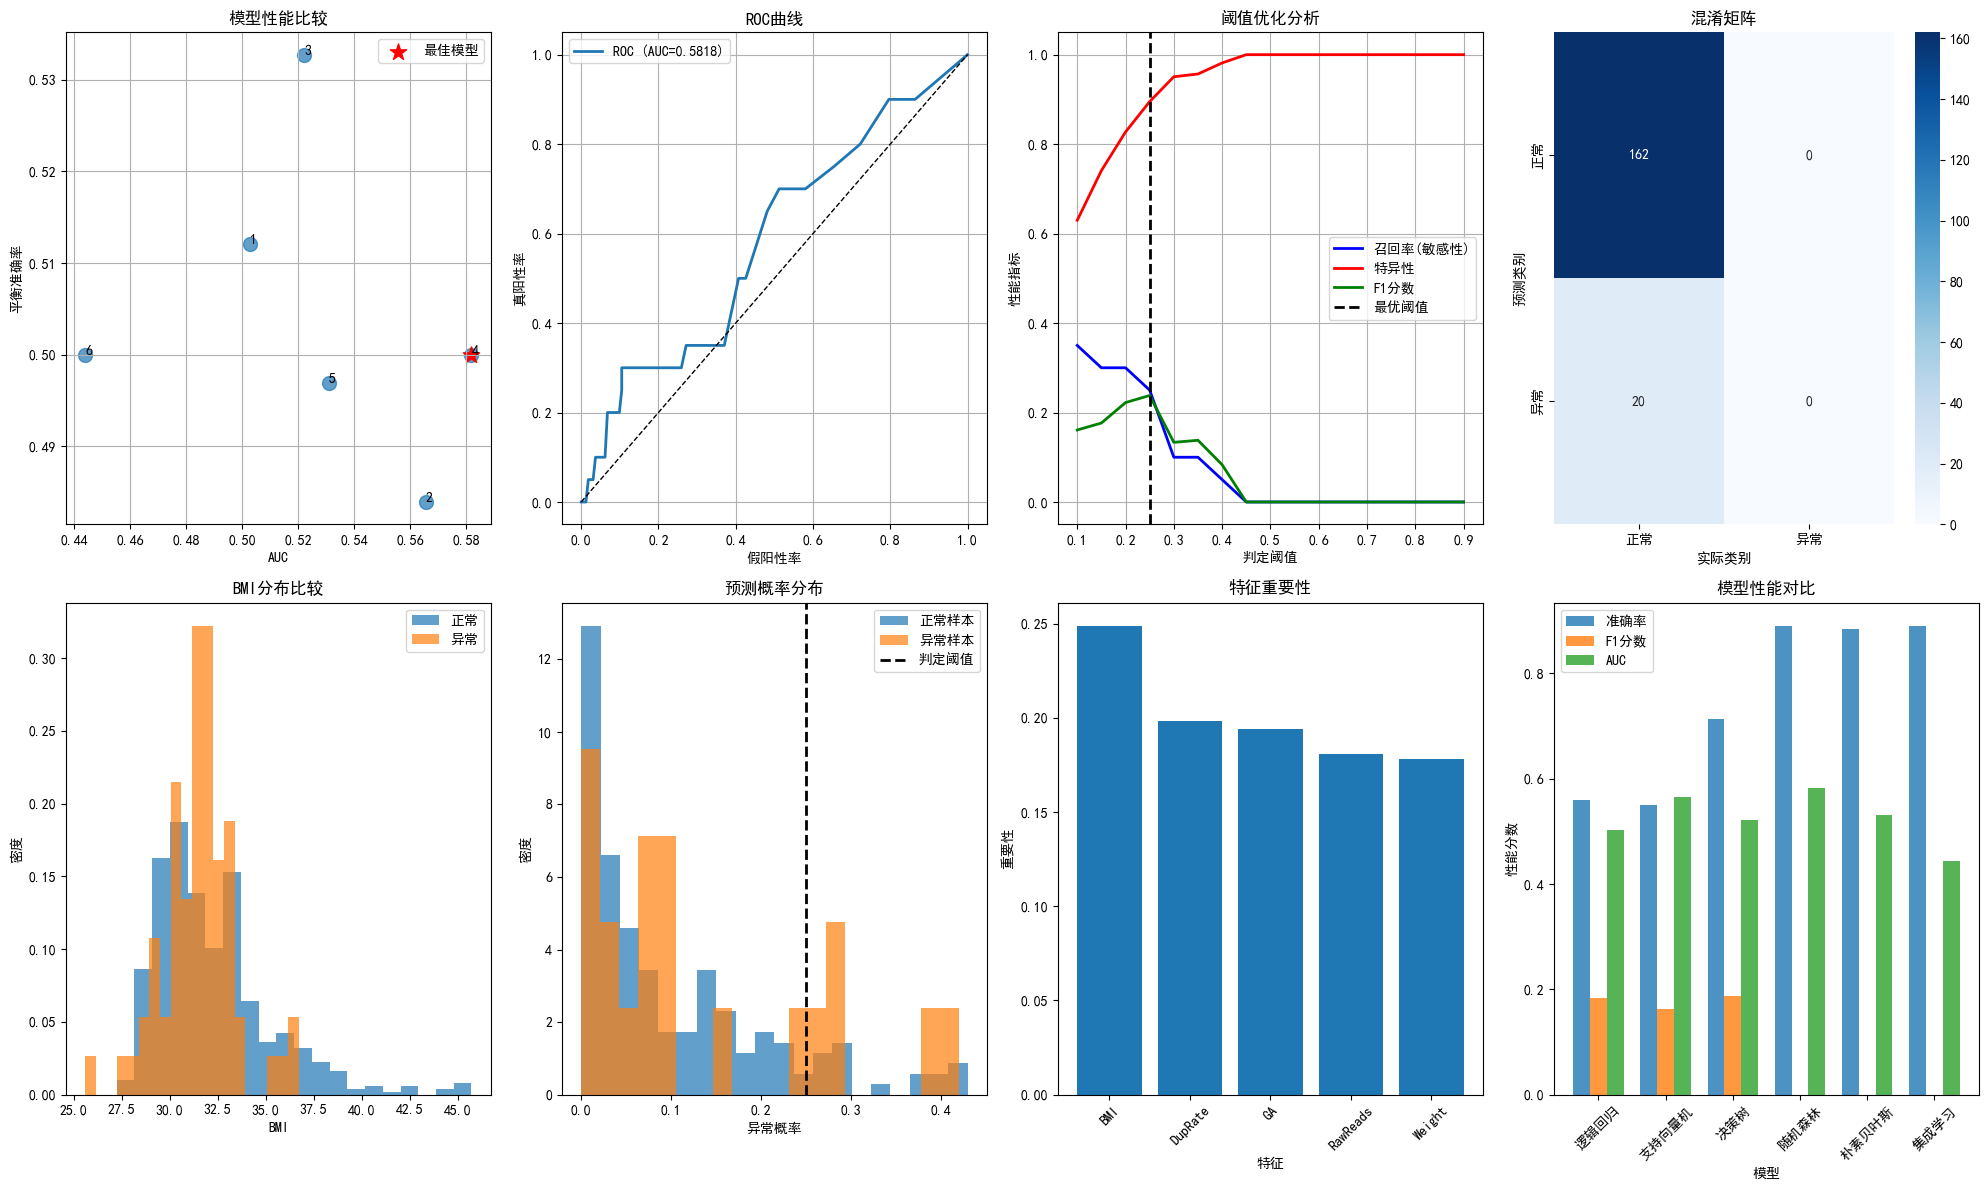


正在保存结果...

=== 结果保存完成 ===
1. 模型比较结果: Q4_分类模型结果.xlsx
2. 模型和参数: Q4_classification_model.pkl
3. 可视化图表: Q4_分类模型可视化结果.png

女胎异常判定模型构建完成！


In [34]:
if __name__ == "__main__":
    results, performance, best_model, threshold = female_fetus_classification()